In [8]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

import os

# sys.path.append('/home/davcic/CP_Testing')

args = 1
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')


Selected GPU 1


In [ ]:
loss_particles = jnp.load("loss_lgp_particles.npy")
z = jnp.mean(loss_particles, axis = 0)
# print(z)

In [19]:
from New_kernel_1 import Discontinuous_multiple
import jaxkern as jk
import distrax as dx
import jax.random as jrnd
import jax
from jax.flatten_util import ravel_pytree


key = jrnd.PRNGKey(12345)

n = 100

x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

params = dict(lengthscale = 0.2,
              variance = 5.0, 
              num = jnp.array([0.3, 0.7]))
base_kernel = jk.RBF()
jitter = 1e-5
kernel = Discontinuous_multiple(base_kernel)
cov = kernel.cross_covariance(params, x, x) + jitter*jnp.eye(len(x))


key_sample, key = jrnd.split(key)
f = dx.MultivariateNormalFullCovariance(jnp.zeros(100), cov).sample(seed = key)
# plt.plot(x, f)
# plt.savefig("Test_data_LossLandscape.png")
# print(dx.MultivariateNormalFullCovariance(jnp.zeros(100), cov).log_prob(f))

vals = jnp.arange(-1e-2, 1e-2+1e-3, 1e-3)
# print(vals)
probs = jnp.zeros((len(vals), len(vals)))
for i, c1 in enumerate(vals):
    for j, c2 in enumerate(vals):
        p, unravel_fn = ravel_pytree(params)
        # change = 0.01
        p = p.at[0].add(c1)
        p = p.at[1].add(c2)
        new_params = unravel_fn(p)
        # print(new_params)
        # new_pos = jax.tree_util.tree_map(jnp.add, params, propose)
        kernel = Discontinuous_multiple(base_kernel)
        jitter = 1e-1
        cov = kernel.cross_covariance(new_params, x, x) + jitter*jnp.eye(len(x))
        probs = probs.at[i, j].set(dx.MultivariateNormalFullCovariance(jnp.zeros(100), cov).log_prob(f))



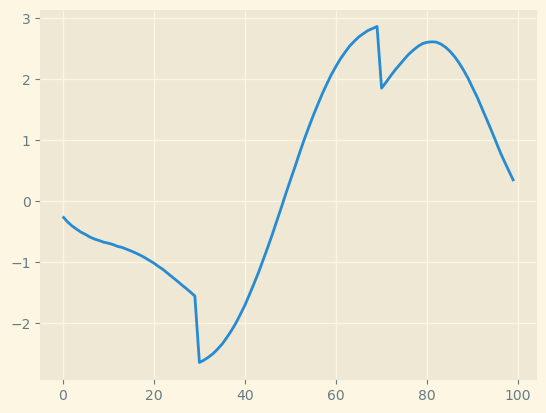

-18001.72


In [20]:
mu = jnp.zeros(100)
jitter = 1e-5

cov = kernel.cross_covariance(params, x, x) + jitter*jnp.eye(len(x))
new_key, key = jrnd.split(key)
sample = dx.MultivariateNormalFullCovariance(mu, cov).sample(seed = new_key)
plt.plot(sample)
# plt.imshow(cov)
# plt.colorbar()
plt.show()
p, unravel_fn = ravel_pytree(params)
change = 0.01
p = p.at[0].add(change)
p = p.at[1].add(change)
new_params = unravel_fn(p)
cov = kernel.cross_covariance(new_params, x, x) + jitter*jnp.eye(len(x))
print(dx.MultivariateNormalFullCovariance(jnp.zeros(100), cov).log_prob(sample))
sample2 = dx.MultivariateNormalFullCovariance(mu, cov).sample(seed = new_key)
# plt.plot(sample2)

# plt.imshow(cov)

plt.show()

In [21]:
# import scipy.special.kl_div as kl_div
jitter = 1e-1
# new_key, key = jrnd.split(key)
cov1 = kernel.cross_covariance(params, x, x) + jitter*jnp.eye(len(x))
dist1 = dx.MultivariateNormalFullCovariance(mu, cov1)

p, unravel_fn = ravel_pytree(params)
change = 0.01
p = p.at[0].add(change)
p = p.at[1].add(change)
new_params = unravel_fn(p)
cov2 = kernel.cross_covariance(new_params, x, x) + jitter*jnp.eye(len(x))
dist2 = dx.MultivariateNormalFullCovariance(mu, cov2)

p, unravel_fn = ravel_pytree(params)
change = 0.001
p = p.at[0].add(change)
p = p.at[1].add(change)
new_params = unravel_fn(p)
cov3 = kernel.cross_covariance(new_params, x, x) + jitter*jnp.eye(len(x))
dist3 = dx.MultivariateNormalFullCovariance(mu, cov3)

# linear = dx.DiagLinear(mu)
# sig = dx.Sigmoid()
# test_dist = dx.MultivariateNormalFromBijector(mu, linear)
# test_dist.kl_divergence
kl_div1 = dist1.kl_divergence(dist2)
kl_div2 = dist1.kl_divergence(dist3)
print(kl_div1)
print(kl_div2)


35.67427
0.0005378723


In [34]:
print(len(vals))

21


<Figure size 1000x600 with 0 Axes>

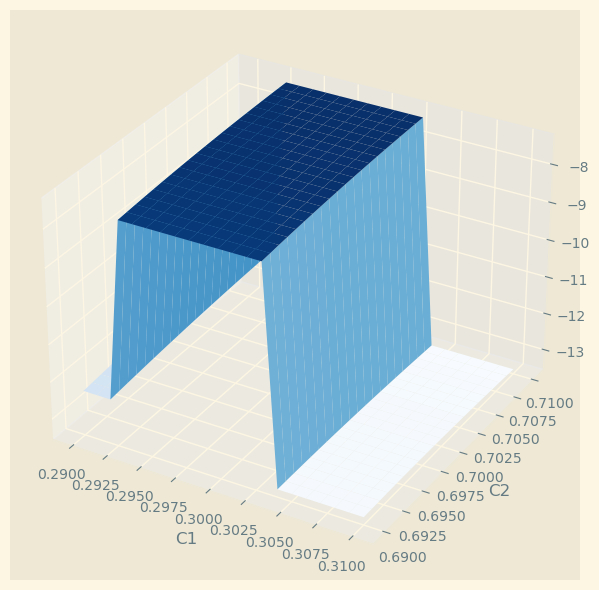

In [22]:
from matplotlib import cm
plt.style.use("Solarize_Light2")
fig = plt.figure(figsize = (10, 6))
size = 21
x = vals+0.3
y = vals+0.7
_xx, _yy = jnp.meshgrid(x, y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (10, 6))
ax.plot_surface(_xx, _yy, probs, vmin=probs.min(), cmap=cm.Blues)
ax.set_xlabel("C1")
ax.set_ylabel("C2")
ax.set_zlabel("log-probability", labelpad=10)
fig.tight_layout()
# plt.show()
plt.savefig(f"Loss_Landscape_jitter_{jitter}.png")

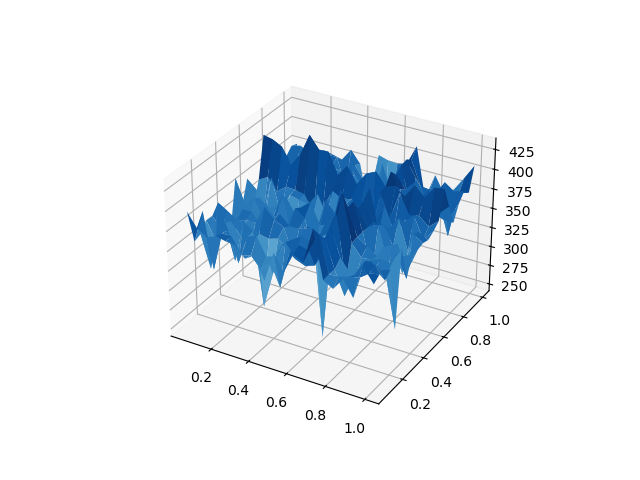

In [3]:
from matplotlib import cm


size = 20
x = jnp.linspace(0.05, 1, size)
y = jnp.linspace(0.05, 1, size)
_xx, _yy = jnp.meshgrid(x, y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(_xx, _yy, z, vmin=z.min(), cmap=cm.Blues)
plt.show()

In [ ]:

size = 20
x = jnp.linspace(0.05, 1, size)
y = jnp.linspace(0.05, 1, size)
_xx, _yy = jnp.meshgrid(x, y)
_x, _y = _xx.ravel(), _yy.ravel()



top = jnp.reshape(z, size*size)
bottom = jnp.zeros_like(top)
width = depth = (3-0.01)/size

ax1 = plt.axes(projection ='3d')
ax1.bar3d(_x, _y, bottom, width, depth, top, shade=True)


# plt.savefig("Loss_Landscape.png")